# Colab D: PyTorch Lightning - 3-Layer Deep Neural Network for Non-Linear Regression

## Overview
- **PyTorch Lightning** framework for cleaner, scalable training
- Same 3-layer deep neural network architecture
- Automatic training loop, logging, and device management
- Same 3-variable non-linear regression problem

### Target Non-Linear Equation
$$y = \sin(x_1) \cdot x_2^2 + \cos(x_3) \cdot x_1 + x_2 \cdot x_3^2$$

### Network Architecture
- Input Layer: 3 neurons
- Hidden Layer 1: 64 neurons (ReLU)
- Hidden Layer 2: 32 neurons (ReLU)
- Hidden Layer 3: 16 neurons (ReLU)
- Output Layer: 1 neuron (Linear)

In [1]:
# ============================================================
# Section 1: Install & Import Dependencies
# ============================================================
!pip install pytorch-lightning -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch: {torch.__version__}")
print(f"PyTorch Lightning: {pl.__version__}")
torch.manual_seed(42)
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 80.4 MB/s eta 0:00:00
PyTorch: 2.10.0+cu128
PyTorch Lightning: 2.6.1


In [2]:
# ============================================================
# Section 2: Data Module (PyTorch Lightning DataModule)
# ============================================================

class NonLinearRegressionDataModule(pl.LightningDataModule):
    """
    PyTorch Lightning DataModule for the 3-variable non-linear regression.
    Handles data generation, normalization, splitting, and DataLoader creation.
    """

    def __init__(self, n_samples=1000, batch_size=64, num_workers=0):
        super().__init__()
        self.n_samples = n_samples
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.X_raw = None
        self.y_raw = None
        self.X_mean = None
        self.X_std = None
        self.y_mean = None
        self.y_std = None

    def setup(self, stage=None):
        # Generate synthetic data
        np.random.seed(42)
        x1 = np.random.uniform(-2, 2, (self.n_samples, 1))
        x2 = np.random.uniform(-2, 2, (self.n_samples, 1))
        x3 = np.random.uniform(-2, 2, (self.n_samples, 1))

        self.y_raw = np.sin(x1) * x2**2 + np.cos(x3) * x1 + x2 * x3**2
        self.X_raw = np.hstack([x1, x2, x3])

        # Normalize
        self.X_mean, self.X_std = self.X_raw.mean(axis=0), self.X_raw.std(axis=0)
        self.y_mean, self.y_std = self.y_raw.mean(), self.y_raw.std()
        X_norm = (self.X_raw - self.X_mean) / self.X_std
        y_norm = (self.y_raw - self.y_mean) / self.y_std

        # Create dataset
        X_t = torch.FloatTensor(X_norm)
        y_t = torch.FloatTensor(y_norm)
        dataset = TensorDataset(X_t, y_t)

        # Split: 80% train, 20% test
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        self.train_dataset, self.test_dataset = random_split(
            dataset, [train_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )

        print(f"Data: {self.n_samples} samples")
        print(f"Train: {train_size}, Test: {test_size}")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                         shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                         shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                         shuffle=False, num_workers=self.num_workers)

# Create data module
dm = NonLinearRegressionDataModule(n_samples=1000, batch_size=64)
dm.setup()
print(f"Batch size: {dm.batch_size}")

Data: 1000 samples
Train: 800, Test: 200
Batch size: 64


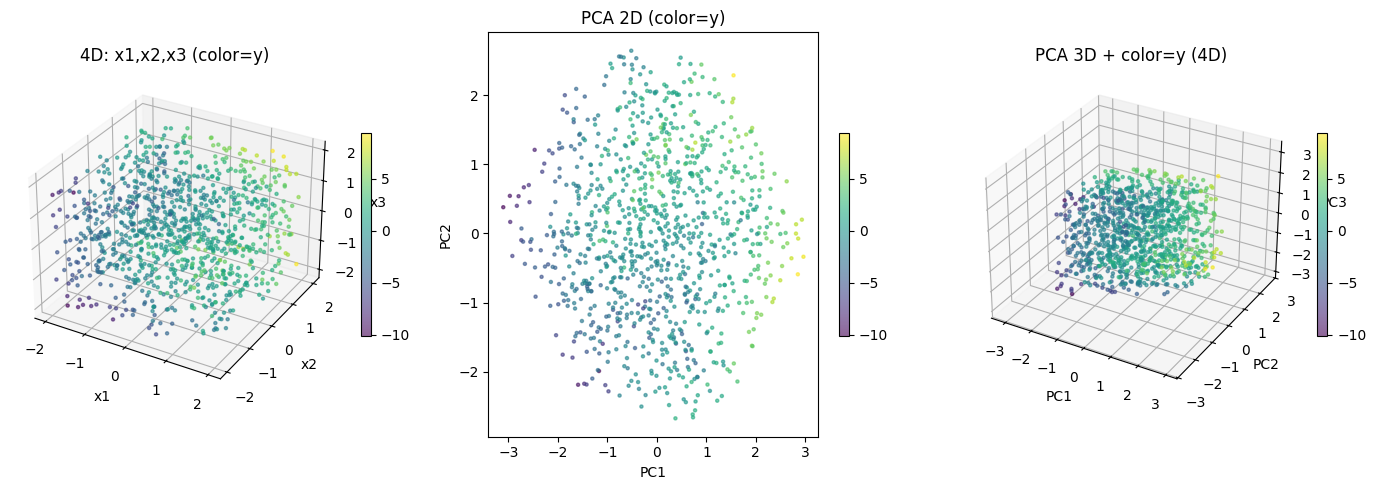

In [3]:
# ============================================================
# Section 3: 4D Data Visualization
# ============================================================
fig = plt.figure(figsize=(14, 5))

X, y = dm.X_raw, dm.y_raw

ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax1.set_xlabel('x1'); ax1.set_ylabel('x2'); ax1.set_zlabel('x3')
ax1.set_title('4D: x1,x2,x3 (color=y)')
plt.colorbar(sc1, ax=ax1, shrink=0.5)

pca2 = PCA(n_components=2)
Xp2 = pca2.fit_transform(X)
ax2 = fig.add_subplot(132)
sc2 = ax2.scatter(Xp2[:, 0], Xp2[:, 1], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax2.set_xlabel('PC1'); ax2.set_ylabel('PC2')
ax2.set_title('PCA 2D (color=y)')
plt.colorbar(sc2, ax=ax2, shrink=0.5)

pca3 = PCA(n_components=3)
Xp3 = pca3.fit_transform(X)
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(Xp3[:, 0], Xp3[:, 1], Xp3[:, 2], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax3.set_xlabel('PC1'); ax3.set_ylabel('PC2'); ax3.set_zlabel('PC3')
ax3.set_title('PCA 3D + color=y (4D)')
plt.colorbar(sc3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

In [4]:
# ============================================================
# Section 4: Lightning Module - 3-Layer DNN
# ============================================================

class ThreeLayerLightningDNN(pl.LightningModule):
    """
    PyTorch Lightning Module for 3-Layer Deep Neural Network.

    Encapsulates:
        - Model architecture
        - Forward pass
        - Training step
        - Validation step
        - Optimizer configuration
    """

    def __init__(self, input_dim=3, h1=64, h2=32, h3=16, output_dim=1, lr=0.001):
        super().__init__()
        self.save_hyperparameters()  # Log hyperparameters
        self.lr = lr

        # 3-Layer Network
        self.network = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, h3),
            nn.ReLU(),
            nn.Linear(h3, output_dim)
        )

        # He initialization
        self._init_weights()

        # Loss
        self.criterion = nn.MSELoss()

        # Store losses for plotting
        self.training_losses = []
        self.validation_losses = []

    def _init_weights(self):
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        avg_loss = self.trainer.callback_metrics.get('train_loss')
        if avg_loss is not None:
            self.training_losses.append(avg_loss.item())

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        avg_loss = self.trainer.callback_metrics.get('val_loss')
        if avg_loss is not None:
            self.validation_losses.append(avg_loss.item())

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=50
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

# Create model
model = ThreeLayerLightningDNN(lr=0.001)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

ThreeLayerLightningDNN(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

Total parameters: 2881


In [5]:
# ============================================================
# Section 5: Training with PyTorch Lightning Trainer
# ============================================================

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=100, mode='min', verbose=True
)

checkpoint = ModelCheckpoint(
    monitor='val_loss', mode='min', save_top_k=1,
    filename='best-{epoch}-{val_loss:.4f}'
)

# Trainer
trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[early_stop, checkpoint],
    enable_progress_bar=True,
    log_every_n_steps=5
)

print("Starting Lightning training...")
trainer.fit(model, dm)
print("\nTraining complete!")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


Starting Lightning training...
Data: 1000 samples
Train: 800, Test: 200


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ network   │ Sequential │  2.9 K │ train │     0 │
│ 1 │ criterion │ MSELoss    │      0 │ train │     0 │
└───┴───────────┴────────────┴────────┴───────┴───────┘

Trainable params: 2.9 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.9 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 9                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.830
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.330 >= min_delta = 0.0. New best score: 0.499
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.137 >= min_delta = 0.0. New best score: 0.362
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.291
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 0.215
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.168
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.133
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.111
INFO:pytorch_lightning.callbacks.ear


Training complete!


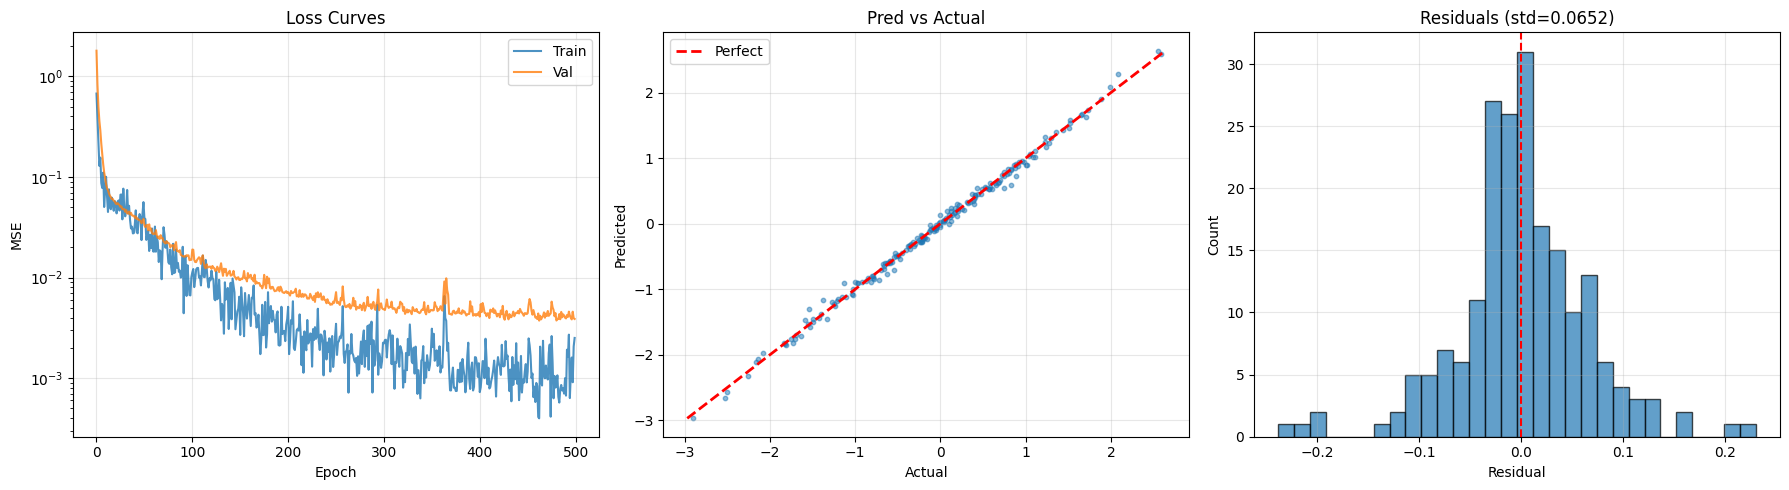

R²: 0.995752
MAE: 0.046275


In [6]:
# ============================================================
# Section 6: Results Visualization
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curves
if model.training_losses and model.validation_losses:
    min_len = min(len(model.training_losses), len(model.validation_losses))
    axes[0].plot(model.training_losses[:min_len], label='Train', alpha=0.8)
    axes[0].plot(model.validation_losses[:min_len], label='Val', alpha=0.8)
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('MSE')
    axes[0].set_title('Loss Curves'); axes[0].legend()
    axes[0].set_yscale('log'); axes[0].grid(True, alpha=0.3)

# Generate predictions
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for X_b, y_b in dm.test_dataloader():
        pred = model(X_b)
        all_preds.append(pred.numpy())
        all_actuals.append(y_b.numpy())

y_pred_np = np.concatenate(all_preds, axis=0)
y_actual_np = np.concatenate(all_actuals, axis=0)

# Predictions vs Actual
axes[1].scatter(y_actual_np, y_pred_np, alpha=0.5, s=10)
mn, mx = min(y_actual_np.min(), y_pred_np.min()), max(y_actual_np.max(), y_pred_np.max())
axes[1].plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect')
axes[1].set_xlabel('Actual'); axes[1].set_ylabel('Predicted')
axes[1].set_title('Pred vs Actual'); axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Residuals
res = (y_actual_np - y_pred_np).flatten()
axes[2].hist(res, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(0, color='r', linestyle='--')
axes[2].set_xlabel('Residual'); axes[2].set_ylabel('Count')
axes[2].set_title(f'Residuals (std={res.std():.4f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

r2 = 1 - np.sum(res**2) / np.sum((y_actual_np - y_actual_np.mean())**2)
print(f"R²: {r2:.6f}")
print(f"MAE: {np.mean(np.abs(res)):.6f}")

In [7]:
# ============================================================
# Section 7: Sample Predictions
# ============================================================

# Denormalize
y_test_orig = y_actual_np * dm.y_std + dm.y_mean
y_pred_orig = y_pred_np * dm.y_std + dm.y_mean

print("Sample Predictions (Original Scale):")
print("=" * 50)
print(f"{'Idx':>5} | {'Actual':>10} | {'Predicted':>10} | {'Error':>8}")
print("-" * 50)
for i in range(15):
    a, p = y_test_orig[i, 0], y_pred_orig[i, 0]
    print(f"{i:5d} | {a:10.4f} | {p:10.4f} | {abs(a-p):8.4f}")

print(f"\nRMSE: {np.sqrt(np.mean((y_test_orig-y_pred_orig)**2)):.4f}")
print(f"R²: {r2:.6f}")

print("\n=== Colab D Complete ===")
print("Key points:")
print("- PyTorch Lightning for organized, scalable training")
print("- LightningModule encapsulates model + training logic")
print("- LightningDataModule for data pipeline")
print("- Built-in callbacks: EarlyStopping, ModelCheckpoint")
print("- Automatic logging and progress tracking")
print("- ReduceLROnPlateau scheduler")

Sample Predictions (Original Scale):
  Idx |     Actual |  Predicted |    Error
--------------------------------------------------
    0 |     1.9532 |     1.8197 |   0.1335
    1 |    -0.6031 |    -0.7724 |   0.1694
    2 |    -2.2873 |    -2.5116 |   0.2244
    3 |    -0.0337 |     0.0254 |   0.0591
    4 |     2.7944 |     2.6823 |   0.1121
    5 |     2.6242 |     2.6789 |   0.0546
    6 |     0.0044 |    -0.1303 |   0.1347
    7 |     0.5947 |     0.5817 |   0.0130
    8 |     0.0134 |     0.3908 |   0.3774
    9 |     0.5998 |     0.6611 |   0.0613
   10 |     3.7033 |     3.7169 |   0.0136
   11 |     2.3618 |     2.3683 |   0.0065
   12 |    -3.4219 |    -3.3458 |   0.0761
   13 |    -3.7718 |    -4.1023 |   0.3305
   14 |    -3.9607 |    -3.9034 |   0.0573

RMSE: 0.1849
R²: 0.995752

=== Colab D Complete ===
Key points:
- PyTorch Lightning for organized, scalable training
- LightningModule encapsulates model + training logic
- LightningDataModule for data pipeline
- Built-in c